In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

#### 1. Loading of dataset

In [2]:
#load the data
data = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/'
'arrhythmia/arrhythmia.data', header=None, sep=',', engine='python')

display(data.head(3))
print(data.info())

,0,1,2,3,4,5,6,7,8,9,...,270,271,272,273,274,275,276,277,278,279
0,75,0,190,80,91,193,371,174,121,-16,...,0.0,9.0,-0.9,0.0,0.0,0.9,2.9,23.3,49.4,8
1,56,1,165,64,81,174,401,149,39,25,...,0.0,8.5,0.0,0.0,0.0,0.2,2.1,20.4,38.8,6
2,54,0,172,95,138,163,386,185,102,96,...,0.0,9.5,-2.4,0.0,0.0,0.3,3.4,12.3,49.0,10


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452 entries, 0 to 451
Columns: 280 entries, 0 to 279
dtypes: float64(120), int64(155), object(5)
memory usage: 988.9+ KB
None


In [3]:
print('%d rows and %d columns' % (data.shape[0],data.shape[1]))
print(np.unique(data[len(data.columns)-1]))
data['arrhythmia'] = data[len(data.columns)-1].map(lambda x: 0 if x==1 else 1)
data = data.drop(len(data.columns)-2, axis=1)
print(data.groupby(['arrhythmia']).size())

452 rows and 280 columns
[ 1  2  3  4  5  6  7  8  9 10 14 15 16]
arrhythmia
0    245
1    207
dtype: int64


In [4]:
data = data._get_numeric_data()
print('%d rows and %d columns' % (data.shape[0],data.shape[1]))
data.head(3)

452 rows and 275 columns


,0,1,2,3,4,5,6,7,8,9,...,270,271,272,273,274,275,276,277,278,arrhythmia
0,75,0,190,80,91,193,371,174,121,-16,...,0.0,9.0,-0.9,0.0,0.0,0.9,2.9,23.3,49.4,1
1,56,1,165,64,81,174,401,149,39,25,...,0.0,8.5,0.0,0.0,0.0,0.2,2.1,20.4,38.8,1
2,54,0,172,95,138,163,386,185,102,96,...,0.0,9.5,-2.4,0.0,0.0,0.3,3.4,12.3,49.0,1


In [5]:
X = data.iloc[:, :-1]  # The first to second-last columns are the features
y = data.iloc[:, -1]   # The last column is the ground-truth label
print(np.unique(y))
print(X.shape)

[0 1]
(452, 274)


#### 2. Splitting of dataset to training and testing data (test_size = 20% of the whole dataset)

In [6]:
# splitting the dataset to training and validation datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20181004)

In [7]:
# Standardizing the training and test datasets
# Note that we are scaling based on the information from the training data
# Then we apply the scaling that is done from training data to the test data
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

#### 3. Building of a self-designed Logistic Regression model

In [8]:
class LogisticRegression(object):

    def __init__(self, eta=0.05, n_epoch=100, random_state=1, lambda_L1 = 0, lambda_L2 = 0):
        """Feel free to change the hyperparameters"""
        self.eta = eta
        self.n_epoch = n_epoch
        self.random_state = random_state
        self.lambda_L1 = lambda_L1
        self.lambda_L2 = lambda_L2

    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_epoch):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            gradient_weights, gradient_bias = self.gradient(X, output, y)
            #self.w_[1:] += self.eta * gradient_weights
            self.w_[1:] += self.eta * (gradient_weights - self.lambda_L1 * np.sign(self.w_[1:]) - 2 * self.lambda_L2 * self.w_[1:])
            self.w_[0] += self.eta * gradient_bias
            cost = self.loss(output, y)
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def loss(self, output, y):
        """Calculate cross entropy loss"""
        # TODO
        epsilon = 1e-15  #deal with the problem of divide by 0 encountered in log
        output = np.clip(output, epsilon, 1 - epsilon)  # Clip output values to be in (epsilon, 1-epsilon)
        return -np.mean(y * np.log(output) + (1 - y) * np.log(1 - output))
        #pass

    def gradient(self, X, output, y):
        """Calculate the partial derivative of cross entropy loss with respect to weights"""
        errors = (y - output)
        return errors.dot(X), errors.sum()

    def activation(self, z):
        """Compute logistic sigmoid activation"""
        # TODO
        return 1.0 / (1.0 + np.exp(-z))
        #pass

    def predict(self, X):
        """Return class label after unit step"""
        # TODO
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)
        #pass

In [46]:
model = LogisticRegression(eta=0.01, n_epoch=350)
model.fit(X_train_std, y_train)
y_pred = model.predict(X_test_std)

#### 4. Plotting the loss curve.

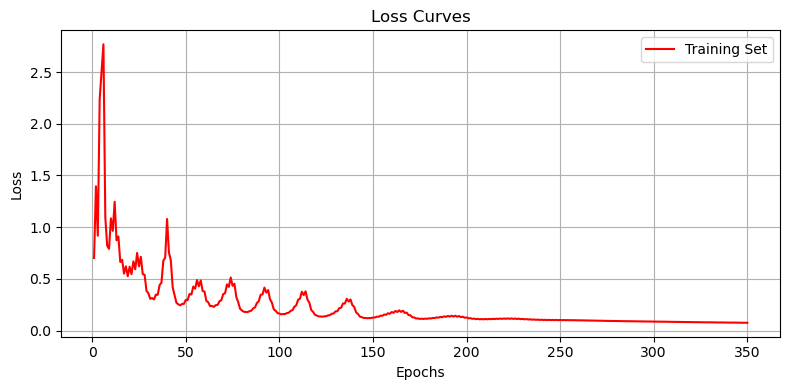

In [47]:
train_loss = model.cost_
def loss_curve(train_loss):
    # Plot the combined loss curve
    plt.figure(figsize=(8, 4))  # Set the figure size
    
    # Plot the training set loss curve in blue
    plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Set', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.savefig('./output/fig-logistic-regression-loss-curve.png', dpi=300)
    plt.show()
    
loss_curve(train_loss)

#### 5. Plotting of the confusion matrix. (Label 0 as positive)

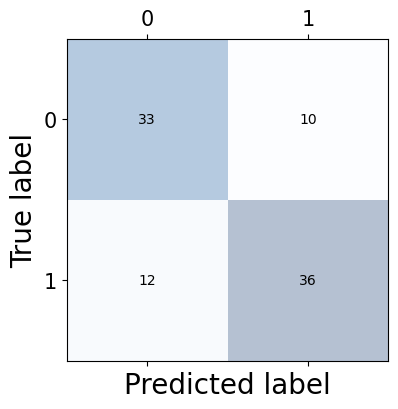

In [48]:
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
fig, ax = plt.subplots(figsize=(4,4))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.savefig('./output/fig-logistic-regression-confusion.png', dpi=300)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)
plt.show()

#### 6. Computing the F1-score of this confusion matrix. The F1-score should be at least 0.75

In [49]:
# Calculate the F1-score
f1 = f1_score(y_test, y_pred)
print(f"F1-Score: {f1:.2f}")

F1-Score: 0.77
